In [74]:
import gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from gym import spaces


In [92]:
class CryptoEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data_df, max_buy=np.inf, min_buy=0, max_sell=np.inf, min_sell=0, transaction_fee=1e-3,
                 initial_capital=0, period=100, reward_period=50, eps=1e-7) -> None:
        super(CryptoEnv, self).__init__()
        # TODO: moving average -> buy and sell signal 
        # transaction difference buy/sell

        # load eth data (test)
        self.data = data_df
        self.data.dropna(inplace=True)
        self.data.sort_values(by='time', ascending=True, inplace=True)

        self.cnt_max = len(self.data) - period - 1

        self.max_buy = max_buy
        self.max_sell = max_sell
        self.min_buy = min_buy
        self.min_sell = min_sell
        self.transaction_fee = transaction_fee
        self.period = period
        self.reward_period = reward_period
        self.date_cnt = 0
        self.eps = eps
        # crypto wallet
        self.initial_capital = initial_capital
        self.wallet = initial_capital
        self.wallet_usd = 0
        self.bs_record = deque([], maxlen=reward_period)

        # action space: buy or sell
        self.action_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        # observations: past 'period' days' observation, (PriceUSD, AdrActCnt)
        # observation shape: (2, period) (currently)
        self.observation_space = spaces.Box(
            low=(-np.inf), high=np.inf, shape=(2, self.period), dtype=np.float32)

    def _load_period(self):
        return self.data.iloc[self.date_cnt:self.date_cnt + self.period][['AdrActCnt', 'PriceUSD']].sort_index(
            ascending=False).reset_index()

    def _get_current_price(self):
        return self._load_period()[0]

    def _get_obs(self):
        # get current observation
        return self._load_period().values.astype(np.float32)

    def _get_roi(self):
        # calculate roi
        bs_record_np = np.array(self.bs_record)
        bs_record_pos = bs_record_np[bs_record_np > 0].sum()
        bs_record_neg = bs_record_np[bs_record_np < 0].sum()
        # print(f'record: {self.bs_record}')
        roi = np.divide(bs_record_pos, -bs_record_neg + self.eps)
        return roi

    def step(self, action):
        info = {}
        reward = 0
        # positive action: buy, negative action: sell
        # detect whether exceed the limit
        is_buy = np.sign(action[0]) > 0
        # print(f'buy: {is_buy}')
        abs_val = np.abs(action[0])
        price_usd = self._load_period()['PriceUSD'].iloc[0]

        if is_buy:
            # check limit
            if abs_val < self.min_buy or abs_val > self.max_buy:
                reward = -10
                self.date_cnt += 1
                # TODO: return
                done = True
                return self._get_obs(), reward, done, {}
            # buy process
            payload = (price_usd * abs_val) * (1 + self.transaction_fee)
            self.bs_record.append(-payload)
            self.wallet_usd -= payload
            self.wallet += abs_val
        else:
            # check limit & wallet
            # print('selling!')
            if abs_val < self.min_sell or abs_val > self.max_sell or abs_val > self.wallet:
                # print('abort!')
                reward = -10
                self.date_cnt += 1
                # TODO: return
                done = True
                return self._get_obs(), reward, done, {}
            # sell process
            payload = (price_usd * abs_val) * (1 + self.transaction_fee)
            # print(f'sell payload: {payload}')
            self.bs_record.append(payload)
            self.wallet_usd += payload
            self.wallet -= abs_val

        # TODO: calculate ROI for reward
        reward = self._get_roi()
        observation = self._get_obs()
        done = False
        # if is done
        if self.date_cnt >= self.cnt_max:
            done = True

        self.date_cnt += 1

        return observation, reward, done, info

    def reset(self):
        # clear chache and reset observation
        self.date_cnt = 0
        self.wallet = self.initial_capital
        self.wallet_usd = 0
        self.bs_record = deque([], maxlen=self.reward_period)
        return self._get_obs()

    def render(self, **kwargs):
        print(
            f'Step: {self.date_cnt}\t ROI: {self._get_roi():.4f}\t wallet: {self.wallet:.4f} ETH')


In [94]:
env = CryptoEnv(data_df=pd.read_csv('eth.csv'))

observation, reward, done, _ = env.step(np.array([-100]))
env.render()
env.reset()
observation, reward, done, _ = env.step(np.array([100]))
env.render()
observation, reward, done, _ = env.step(np.array([100]))
env.render()
observation, reward, done, _ = env.step(np.array([-50]))
env.render()
observation, reward, done, _ = env.step(np.array([-100]))
env.render()
observation, reward, done, _ = env.step(np.array([10000]))
env.render()

env.reset()
action = env.action_space.sample()
print(f'random action: {action}')
observation, reward, done, _ = env.step(action)
env.render()

action = env.action_space.sample()
print(f'random action: {action}')
observation, reward, done, _ = env.step(action)
env.render()

action = env.action_space.sample()
print(f'random action: {action}')
observation, reward, done, _ = env.step(action)
env.render()


Step: 1	 ROI: 0.0000	 wallet: 0.0000 ETH
Step: 1	 ROI: 0.0000	 wallet: 100.0000 ETH
Step: 2	 ROI: 0.0000	 wallet: 200.0000 ETH
Step: 3	 ROI: 0.2474	 wallet: 150.0000 ETH
Step: 4	 ROI: 0.7379	 wallet: 50.0000 ETH
Step: 5	 ROI: 0.0154	 wallet: 10050.0000 ETH
random action: [1.6411262]
Step: 1	 ROI: 0.0000	 wallet: 1.6411 ETH
random action: [0.01357794]
Step: 2	 ROI: 0.0000	 wallet: 1.6547 ETH
random action: [-1.1807035]
Step: 3	 ROI: 0.7138	 wallet: 0.4740 ETH


In [88]:
env.action_space.sample()

array([1.2945625], dtype=float32)

In [48]:
data = pd.read_csv('eth.csv')
data.dropna(inplace=True)
data.sort_values(by='time', ascending=True, inplace=True)
data = data.iloc[0:100][['AdrActCnt', 'PriceUSD']].sort_index(ascending=False)
data.values.astype(np.float32)

array([[1.61360000e+04, 1.00172281e+01],
       [1.76730000e+04, 1.01176767e+01],
       [1.62390000e+04, 9.88841057e+00],
       [1.76740000e+04, 1.02900543e+01],
       [1.62050000e+04, 1.05204115e+01],
       [1.74880000e+04, 1.06574669e+01],
       [1.69820000e+04, 1.08588095e+01],
       [1.81750000e+04, 1.09156866e+01],
       [1.50050000e+04, 1.09939137e+01],
       [1.64880000e+04, 1.11425228e+01],
       [1.33750000e+04, 1.11541977e+01],
       [1.93920000e+04, 1.08688612e+01],
       [2.11270000e+04, 1.08340807e+01],
       [2.06450000e+04, 1.08072023e+01],
       [1.99670000e+04, 1.09769831e+01],
       [1.54500000e+04, 1.12365084e+01],
       [1.71490000e+04, 1.04133396e+01],
       [1.88380000e+04, 1.11283607e+01],
       [1.87720000e+04, 1.14758968e+01],
       [1.90130000e+04, 1.14940481e+01],
       [1.94010000e+04, 1.13266439e+01],
       [1.89020000e+04, 1.19264431e+01],
       [1.77490000e+04, 1.19570141e+01],
       [1.90930000e+04, 1.20438585e+01],
       [2.329900

In [201]:
data = pd.read_csv('eth.csv')

env = CryptoEnv(data_df=data)
env._load_period()['PriceUSD'].iloc[0]


10.0172283571011

In [203]:
dq = deque([], maxlen=100)

In [209]:
dq.append(10)

In [206]:
dq

deque([10])

In [210]:
sum(dq)

20

In [7]:
dq = deque([1, -2, 1, -1], maxlen=100)
dq = np.array(dq)
dq = dq[dq < 0]
dq

array([-2, -1])

array([ 1, -1,  1, -1])

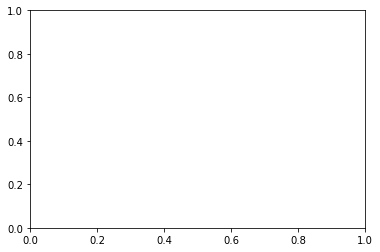

In [77]:
fig, ax = plt.subplots()